In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import helper

import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss


FIXED_SIZE = 32

def load_image(imagePath):
    im = cv2.imread(imagePath)[...,::-1]
    im = cv2.resize(im, (FIXED_SIZE, FIXED_SIZE))
    return im

def load_dataset(isTraining):

    image_folder = "./input_images/"
    mask_folder = "./input_masks/"

    masks = sorted(glob.glob(os.path.join(mask_folder, "*.png")))
    images = []
    for mask_path in masks:
        images.append(os.path.join(image_folder, ((mask_path.split('/')[-1]).split("_mask.png")[0] + ".png")))

    dataSize = len(images)

    input_images = np.zeros((dataSize, FIXED_SIZE, FIXED_SIZE, 3))
    target_masks = np.zeros((dataSize, 1, FIXED_SIZE, FIXED_SIZE))

    for i, image in enumerate(images):
        im = load_image(image)
        input_images[i] = im

    for i, mask in enumerate(masks):
        mask = load_image(mask)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        mask = mask.astype('bool')
        target_masks[i][0] = mask
    
    trainSize = int(dataSize * 0.8)

    if isTraining:
        train_images = input_images[:trainSize,...]
        train_masks = target_masks[:trainSize,...]
        return train_images.astype(np.uint8), train_masks
    else:
        val_images = input_images[trainSize:,...]
        val_masks = target_masks[trainSize:,...]
        return val_images.astype(np.uint8), val_masks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(3, 32, 32, 3)
0 251
(3, 1, 32, 32)
0.0 1.0


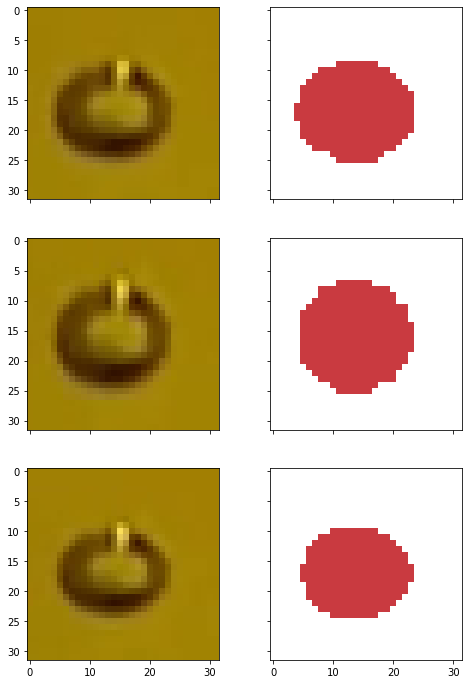

In [7]:
input_images, target_masks = load_dataset(True)
selected_input_images = input_images[:3,...]
selected_target_masks = target_masks[:3,...]

for x in [selected_input_images, selected_target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in selected_input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in selected_target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [8]:
class SimDataset(Dataset):
    def __init__(self, isTraining, transform=None):
        self.input_images, self.target_masks = load_dataset(isTraining)
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(True, transform = trans)
val_set = SimDataset(False, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 3952, 'val': 989}

torch.Size([25, 3, 32, 32]) torch.Size([25, 1, 32, 32])
0.0 1.0 0.42006013 0.29924074
0.0 1.0 0.226640625 0.41865815661421124


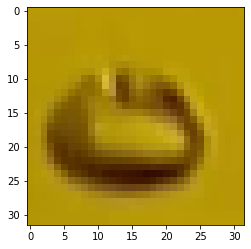

In [9]:
def reverse_transform(inp):

    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(1)
model = model.to(device)

summary(model, input_size=(3, FIXED_SIZE, FIXED_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [11]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 1

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50)

# save model
torch.save(model.state_dict(), "./saved_model/model.pth")

Epoch 0/49
----------
LR 0.0001


/home/nus/miniforge3/envs/torch-tf-gpu/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/nus/miniforge3/envs/torch-tf-gpu/lib/python3.9/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.287629, dice: 0.310870, loss: 0.299250
val: bce: 0.178202, dice: 0.204559, loss: 0.191381
saving best model
0m 4s
Epoch 1/49
----------
LR 0.0001
train: bce: 0.089140, dice: 0.102320, loss: 0.095730
val: bce: 0.070706, dice: 0.080513, loss: 0.075610
saving best model
0m 3s
Epoch 2/49
----------
LR 0.0001
train: bce: 0.060521, dice: 0.066436, loss: 0.063479
val: bce: 0.050735, dice: 0.054368, loss: 0.052552
saving best model
0m 3s
Epoch 3/49
----------
LR 0.0001
train: bce: 0.052972, dice: 0.056370, loss: 0.054671
val: bce: 0.044947, dice: 0.050100, loss: 0.047524
saving best model
0m 3s
Epoch 4/49
----------
LR 0.0001
train: bce: 0.049548, dice: 0.052710, loss: 0.051129
val: bce: 0.071857, dice: 0.063325, loss: 0.067591
0m 3s
Epoch 5/49
----------
LR 0.0001
train: bce: 0.048127, dice: 0.051133, loss: 0.049630
val: bce: 0.051161, dice: 0.052342, loss: 0.051751
0m 3s
Epoch 6/49
----------
LR 0.0001
train: bce: 0.047429, dice: 0.050178, loss: 0.048804
val: bce: 0.043824, dic

(3, 1, 32, 32)


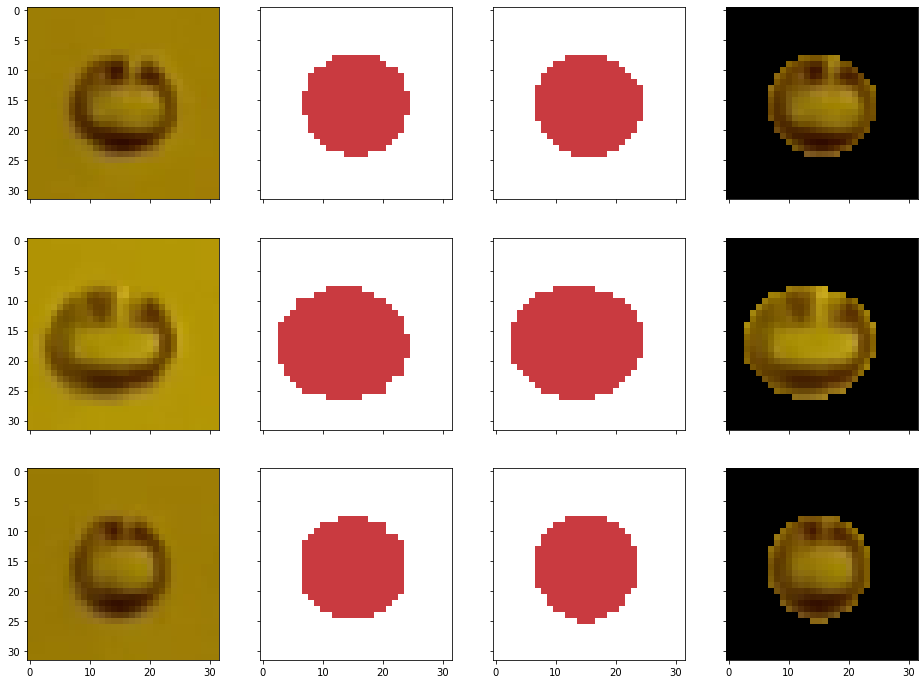

In [25]:
# prediction

# load model
model = pytorch_unet.UNet(num_class).to(device)
model.load_state_dict(torch.load("./saved_model/model.pth"))
model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(False, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

masked_inputs = []

for i in range(3):
    mask = cv2.cvtColor(pred_rgb[i], cv2.COLOR_RGB2GRAY)
    mask = 255 - mask
    masked = cv2.bitwise_and(input_images_rgb[i], input_images_rgb[i], mask=mask)
    masked_inputs.append(masked)

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb, masked_inputs])